## 基于文本的情感分析
### 数据支持：golve.6B.300d.txt (下载链接https://nlp.stanford.edu/projects/glove/）
### 训练集文件：isear.txt stopwords_english.txt
### 模型使用：Logistic模型 集成学习相关模型(Randam Forest GBDT) bi-LSTM神经网络
### 项目时间：2020年4月25日

### Part 1 导入文本数据及预处理过程(去除特殊符号、停用词等) 

In [1]:
# 导入re库，用正则表达式(基于规则的方式)去除文本数据的特殊符号，对一些单词的缩写进行展开等
import re

# 导入isear.txt文件，提取文件中的文本信息和情感标签
contents, targets = [], []
for line in open('isear.txt', encoding='utf-8'):
    line = line.strip().split('|')
    tar, cont = line[-7], line[-3]
    if re.match(r'[0-9]+', tar) or len(tar.split(' '))>1:
        continue
    else:
        targets.append(tar)
        contents.append(cont)

# 去掉header
contents.pop(0)
targets.pop(0)

# 导入停用词库
stop_words = []
for line in open('/Users/xujie/Desktop/Python/nlp/data/data_english/stopwords_english.txt'):
    stop_words.append(line.strip())


# 定义函数clean_text对文本进行清洗
def clean_text(cont, lower_flag=False):
    if lower_flag: 
        cont = cont.lower()
    cont = re.sub(r"what's", "what is ", cont)
    cont = re.sub(r"\'s", " ", cont)
    cont = re.sub(r"\'ve", " have ", cont)
    cont = re.sub(r"can't", "can not ", cont)
    cont = re.sub(r"n't", " not ", cont)
    cont = re.sub(r"i'm", "i am ", cont)
    cont = re.sub(r"\'re", " are ", cont)
    cont = re.sub(r"\'d", " would ", cont)
    cont = re.sub(r"\'ll", " will ", cont)
    cont = re.sub(r",", " ", cont)
    cont = re.sub(r"\.", " ", cont)
    cont = re.sub(r"!", " ! ", cont)
    cont = re.sub(r":", " : ", cont)
    ont = re.sub(r";", " ; ", cont)
    cont = re.sub(r"/", " ", cont)
    cont = re.sub(r"\\", " ", cont)
    cont = re.sub(r"\t", " ", cont)
    cont = re.sub(r"\[", " ", cont)
    cont = re.sub(r"\]", " ", cont)
    cont = re.sub(r"\(", " ", cont)
    cont = re.sub(r"\)", " ", cont)
    cont = re.sub(r"-", " ", cont)
    cont = re.sub(r"%", " ", cont)
    cont = re.sub(r"&", " ", cont)
    cont = re.sub(r"$", " ", cont)
    cont = re.sub(r"'", " ", cont)
    cont = re.sub(r"\"", " ", cont)
    cont = re.sub(r"¦", " ", cont)
    cont = cont.strip().split()
    return cont

for i in range(len(contents)):
    contents[i] = clean_text(contents[i], lower_flag=True)
    # 去除停用词
    contents[i] = ' '.join([word for word in contents[i] if word not in stop_words])

# print文本和情感表情的一些例子
for i in range(10):
    print('text:', contents[i])
    print('emotion:', targets[i], '\n')

text: period falling love time met especially met long time
emotion: joy 

text: involved traffic accident
emotion: fear 

text: driving home several days hard work motorist ahead driving 50 km hour refused despite low speeed let overtake
emotion: anger 

text: lost person meant
emotion: sadness 

text: time knocked deer sight animal injuries helplessness realization animal badly hurt put animal screamed moment death
emotion: disgust 

text: speak truth
emotion: shame 

text: caused problems somebody could keep appointed time led various consequences
emotion: guilt 

text: got letter offering summer job applied
emotion: joy 

text: going home alone one night paris man came behind asked afraid alone late night
emotion: fear 

text: talking party first time long friend came interrupted us left
emotion: anger 



### Part 2 基于机器学习和集成学习的情感分析预测 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 设置随机数种子
SEED = 1234

# 将文本和标签划分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(contents, targets, test_size=0.3, random_state=SEED)

# 对文本中对每一句化进行one-hot(tf-idf) encoder
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

### Part 2.1 通过Logistic Regression对训练集样本进行试探性的训练

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.linear_model import LogisticRegression

# 训练Logistic Regression Model并在测试集上进行预测得分
# tf-idf encoding的方式本身具有极大的稀疏性，加入L1正则对特征进行稀疏学习，相应的solver为saga
lr = LogisticRegression(C=2.5, penalty='l1', solver='saga', tol=0.0001)
# print测试集得分score
print('logistic模型在测试集上的得分为:', lr.fit(X_train, Y_train).score(X_test, Y_test))
# print带L1正则项Logistic Regression Model参数的稀疏率
print('logistic模型训练参数的稀疏率为：{:.2f}%'.format(np.mean(lr.coef_==0)*100))

logistic模型在测试集上的得分为: 0.5468680586406042
logistic模型训练参数的稀疏率为：94.19%


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 导入sklearn.metrics库中的混淆矩阵和分类结果评估模块
from sklearn.metrics import confusion_matrix, classification_report

# 定义report_results()函数，对模型预测的情感标签与真实的情感标签进行分析
def report_results(Y_test, pred, method=''):
    labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
    confm = confusion_matrix(Y_test, pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(confm.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('True Label')
    plt.ylabel('Predict Label')
    plt.xticks([i+0.5 for i in range(7)], labels)
    plt.yticks([i+0.5 for i in range(7)], labels)
    plt.title(method+' '+'Confusion Matrix')
    plt.show()
    
    print(method+' '+'Classification Report：', '\n', classification_report(Y_test, pred))
    return

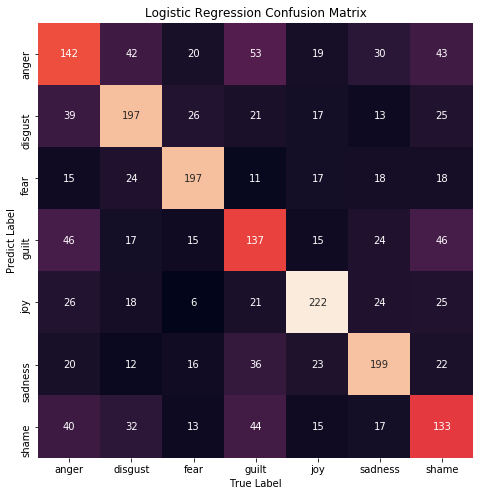

Logistic Regression Classification Report： 
               precision    recall  f1-score   support

       anger       0.41      0.43      0.42       328
     disgust       0.58      0.58      0.58       342
        fear       0.66      0.67      0.66       293
       guilt       0.46      0.42      0.44       323
         joy       0.65      0.68      0.66       328
     sadness       0.61      0.61      0.61       325
       shame       0.45      0.43      0.44       312

    accuracy                           0.55      2251
   macro avg       0.54      0.55      0.54      2251
weighted avg       0.54      0.55      0.54      2251



In [38]:
# pred为Logistic Regression Model在测试集上的预测结果
pred = lr.predict(X_test)
# 绘制混淆矩阵的热力图和classification的评估报告
report_results(Y_test, pred, method='Logistic Regression')

### Part 2.2 通过集成学习方法对训练集进行训练

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# 集成学习模型1: Random Forest
modelRF = RandomForestClassifier(n_estimators=2000, # 弱分类器个数
                                 max_features='sqrt', # 定义max_features
                                 max_depth=None, # 定义最大深度
                                 min_samples_split=8, # 决策树最小样本的划分数
                                 random_state=SEED)

# 集成学习模型2: Extra Trees
modelXT = ExtraTreesClassifier(n_estimators=2000, # 弱分类器个数
                               max_features='sqrt', # 定义max_features
                               max_depth=None, # 定义最大深度
                               min_samples_split=8, # 决策树最小样本的划分数
                               random_state=SEED)

# 集成学习模型3: GBDT
modelGB = GradientBoostingClassifier(n_estimators=200, # 弱分类器个数
                                     learning_rate=0.20, # 定义学习率
                                     max_depth=20, # 定义最大深度
                                     min_samples_split=8, # 定义决策树最小样本的划分数
                                     random_state=SEED)

# 在训练集上训练3种集成学习模型(Random Forest, Extra Trees, GBDT)
modelRF.fit(X_train, Y_train) 
modelXT.fit(X_train, Y_train) 
modelGB.fit(X_train, Y_train)

# 在测试集上测试3种集成学习模型(Random Forest, Extra Trees, GBDT)
pred_lRF = modelRF.predict(X_test)
pred_lXT = modelXT.predict(X_test)
pred_lGB = modelGB.predict(X_test)

In [ ]:
# 绘制混淆矩阵的热力图和classification的评估报告
report_results(Y_test, pred_lRF, method='Random Forest')
report_results(Y_test, pred_lXT, method='Extra Trees')
report_results(Y_test, pred_lGB, method='Gradient Boosting')

### Part 3 基于bi-LSTM深度神经网络对文本进行情感分析

In [5]:
# 导入os库，获取当前工作路径
import os 
# 导入pickle库，用于读取和保存数据
import pickle

# 导入tensorflow, keras深度学习框架
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [21]:
# 根据所有的文本语料数据构建词库构建词库，对文本中的所有单词进行一对一的编码

# 生成词典库
vocab = set([word for line in contents for word in line.split()])

# 对词典库中所有单词分配一个数字，word2idx为将单词转化为对应数字的map，idx2word为将数字转化为相应单词的map
word2idx, idx2word, count = dict(), dict(), 3
for word in vocab:
    count += 1
    word2idx[word] = count
    idx2word[count] = word

# 加入特殊符号：<PAD>表示0填充，<START>表示句子开头，<UNK>表示未在词典库中的单词，<END>表示句子结尾
word2idx['<PAD>'], word2idx['<START>'], word2idx['<UNK>'], word2idx['<END>'] = 0, 1, 2, 3
idx2word[0], idx2word[1], idx2word[2], idx2word[3] = '<PAD>', '<START>', '<UNK>', '<END>'

# 定义文本编码函数content_encoder(), 将文本转化为数字序列
# 设置句子最大长度max_sent_len，不足词长度用0填充，超出此长度对句子进行截断
def content_encoder(word2idx, contents, max_sent_len):
    cont2idx = np.array([[word2idx.get(word, word2idx['<UNK>']) for word in line.split()] for line in contents])
    cont2idx = keras.preprocessing.sequence.pad_sequences(cont2idx, value = 0, padding = 'post', maxlen=max_sent_len)
    return cont2idx

max_sent_len = 30 # 句子最大长度

# 将文本编码为数字序列
cont2idx = content_encoder(word2idx, contents, max_sent_len)

In [22]:
# 加载glove.6B.300d的word2idx数据(用于将句子中的单词转化为对应的数字序号)

config_path = '/Users/xujie/Desktop/Python/nlp/data/word_embeding' # 参数加载地址

with open(os.path.join(config_path, 'word2idx.pickle'), 'rb') as f:
    GloVe_word2idx = pickle.load(f)

# 调用文本编码函数content_encoder(), 将文本转化为数字序列
GloVe_cont2idx = content_encoder(GloVe_word2idx, contents, max_sent_len)

In [23]:
target2idx = {'anger':0, 'disgust':1, 'fear':2, 'guilt':3, 'joy':4, 'sadness':5, 'shame':6}
tar2idx = [target2idx[tar] for tar in targets]

tar_kinds = 7 # 情感标注的类别数

# 对情感标注进行one-hot encoding
target_one_hot = tf.one_hot(tar2idx, depth=tar_kinds)

In [24]:
# 定义save_data()函数将文本的数字序列划分为训练集和测试集并保存
def save_data(X, y, train_rate, file_path):
    sample_size = X.shape[0]
    train_size = int(train_rate*sample_size) 
    test_size = sample_size-train_size
    
    # 划分样本为训练集和测试集
    x_train, x_test = tf.split(X, [train_size, test_size], axis=0)
    y_train, y_test = tf.split(y, [train_size, test_size], axis=0)
    
    # 保存x_train, y_train, x_test, y_test数据(.pickle格式)
    with open(os.path.join(file_path, 'x_train'), 'wb') as f:
        pickle.dump(x_train, f)
    with open(os.path.join(file_path, 'y_train'), 'wb') as f:
        pickle.dump(y_train, f)
    with open(os.path.join(file_path, 'x_test'), 'wb') as f:
        pickle.dump(x_test, f)
    with open(os.path.join(file_path, 'y_test'), 'wb') as f:
        pickle.dump(y_test, f)
    return

file_path = os.getcwd() # 将训练测试数据的保存地址定义为当前工作路径

# 调用save_data()保存训练集和测试集数据
save_data(GloVe_cont2idx, target_one_hot ,0.7, file_path)

## 重点：定义biLSTM类

In [27]:
class biLSTM:
    
    # 类的初始化
    def __init__(self, units, epochs, batch_size, total_words, embed_len, max_sent_len, \
                 tar_kinds, model_path, file_path, config_path=None, callback=True, train=False):
        """
        units: biLSTM层中LSTM基本神经元的个数
        epochs: 模型的最大跌打次数
        batch_size: 单次训练的最大批量
        total_words: 词库中单词的总数
        embed_len: 词嵌入的维度(单词分布式表示的维度)
        max_sent_len: 句子的最大长度
        tar_kinds: 情感标注的类别数
        model_path: 模型保存和加载的路径
        file_path: 训练数据和测试数据的加载路径
        config_path: GloVe词向量weights文件的加载路径
        callback: callback为True训练时采用early stop方案
        train: 判断是否需要重新训练
        """
        
        self.units = units
        self.epochs = epochs
        self.batch_size = batch_size
        self.total_words = total_words
        self.embed_len = embed_len
        self.max_sent_len = max_sent_len
        self.tar_kinds = tar_kinds
        self.model_path = model_path
        self.file_path = file_path
        self.config_path = config_path
        self.config_load_state = False
        self.callback = callback
        
        # 当config_path不为空时，载入GloVe词向量weights文件
        if self.config_path:
            with open(os.path.join(config_path, 'weights.pickle'), 'rb') as f:
                self.weights = pickle.load(f)
            self.config_load_state = True
            
        # 导入训练集和测试集
        self.x_train, self.y_train, self.x_test, self.y_test = self.__load_data() 
        
        # 不重新训练模型时导入保存的模型参数，重新训练模型时调用__train_model()方法
        if not train:
            self.model = self.__load_model()
        else:
            self.model = self.__train_model()
            
        # 对模型进行预测，导出预测结果pred
        self.pred = self.__predict_model()
    
    # __load_data(): 导入训练集和测试集
    def __load_data(self):
        file_path = self.file_path
        with open(os.path.join(file_path, 'x_train'), 'rb') as f:
            x_train = pickle.load(f)
        with open(os.path.join(file_path, 'y_train'), 'rb') as f:
            y_train = pickle.load(f)
        with open(os.path.join(file_path, 'x_test'), 'rb') as f:
            x_test = pickle.load(f)
        with open(os.path.join(file_path, 'y_test'), 'rb') as f:
            y_test = pickle.load(f)
        return x_train, y_train, x_test, y_test
    
    # __load_model(): 导入已经训练好的模型参数
    def __load_model(self):
        try:
            model = self.__build_model()
            model.load_weights(self.model_path)
        except FileNotFoundError:
            print('没有找到模型文件')
            model = None
        return model
    
    # __build_model(): 构建biLSTM深度神经网络
    def __build_model(self):
        # 定义模型的Sequential
        model = Sequential()
        
        if self.config_load_state:
            # 构造Embedding层，以训练好的GloVe词向量为权重，trainable状态为False(表明Embedding层无可训练参数)
            model.add(Embedding(self.total_words, self.embed_len, input_length=self.max_sent_len, \
                                weights=[self.weights], trainable=False))
        else:
            # 构造Embedding层，Embedding层中参数随机初始化，并通过文本数据进行训练
            model.add(Embedding(self.total_words, self.embed_len, input_length=self.max_sent_len))
        
        # add第一层的biLSTM，返回每一个神经元的输出结果，传递到下一层
        model.add(Bidirectional(LSTM(self.units//2, return_sequences=True)))
        # add随机失活层，防止过拟合
        model.add(Dropout(0.4))
        # add第二层的biLSTM，返回最后一个神经元的输出结果，传递到下一层
        model.add(Bidirectional(LSTM(self.units//2, return_sequences=False)))
        # add随机失活层，防止过拟合
        model.add(Dropout(0.4))
        # add全连接层，设置激活函数为softmax(softmax函数常用于多分类任务)
        model.add(Dense(self.tar_kinds, activation='softmax'))
        # 输出模型的计算图
        model.summary()
        
        # 模型编译：优化器为Adam(学习率为0.01), 损失为交叉熵损失函数，判断准则为准确率
        model.compile(optimizer=optimizers.Adam(lr=0.01), 
              loss=losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        return model
    
    # __build_model(): 在训练集上训练biLSTM深度神经网络
    def __train_model(self):
        model = self.__build_model()
        if self.callback:
            # 定义checkpoint: 以验证集的损失为准则，将训练过程中最好的结果保存下来
            checkpoint = ModelCheckpoint('best_model_biLSTM.h5', monitor='val_loss', verbose=True, save_best_only=True)
            # 定义early stop: 以验证集的预测准确率为准则，在模型过拟合之前停止训练
            early_stop = EarlyStopping(monitor='val_accuracy', patience=10)
            # 模型拟合
            model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, shuffle=True, \
                      validation_split=0.2, callbacks=[early_stop, checkpoint])
        else:
            # 模型拟合
            model.fit(self.x_train, self.y_train, epochs=self.epochs, batch_size=self.batch_size, shuffle=True, \
                      validation_split=0.2)
            
        # 保存训练好的模型参数(可将训练过程中表现最好的模型参数进行保存)
        model.save_weights(self.model_path)
        return model
    
    # __build_model(): 在测试集上预测biLSTM深度神经网络
    def __predict_model(self):
        model = self.model
        pred = tf.argmax(model.predict(self.x_test), axis=1)
        # 绘制混淆矩阵的热力图和classification的评估报告
        self.__report_results(pred, method='biLSTM')
        return pred
    
    def __report_results(self, pred, method=''):
        labels = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
        confm = confusion_matrix(tf.argmax(self.y_test, axis=1), pred)
        plt.figure(figsize=(8,8))
        sns.heatmap(confm.T, square=True, annot=True, fmt='d', cbar=False)
        plt.xlabel('True Label')
        plt.ylabel('Predict Label')
        plt.xticks([i+0.5 for i in range(7)], labels)
        plt.yticks([i+0.5 for i in range(7)], labels)
        plt.title(method+' '+'Confusion Matrix')
        plt.show()
        print(method+' '+'Classification Report：', '\n', classification_report(tf.argmax(self.y_test, axis=1), pred))
        return

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 300)           120001200 
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 256)           439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 120,836,535
Trainable params: 835,335
Non-trainable params: 120,001,200
__________________________________

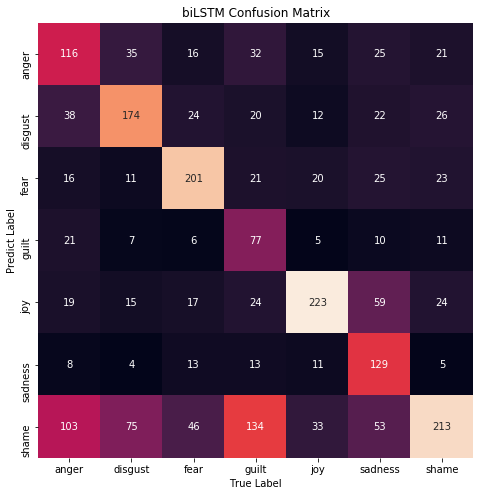

biLSTM Classification Report： 
               precision    recall  f1-score   support

           0       0.45      0.36      0.40       321
           1       0.55      0.54      0.55       321
           2       0.63      0.62      0.63       323
           3       0.56      0.24      0.34       321
           4       0.59      0.70      0.64       319
           5       0.70      0.40      0.51       323
           6       0.32      0.66      0.43       323

    accuracy                           0.50      2251
   macro avg       0.54      0.50      0.50      2251
weighted avg       0.54      0.50      0.50      2251



In [28]:
units = 256
epochs = 40
batch_size = 128
total_words = len(GloVe_word2idx)
embed_len = 300
model_path = os.getcwd()
config_path = '/Users/xujie/Desktop/Python/nlp/data/word_embeding'

# 定义biLSTM类，载入、训练、预测、评估模型
My_biLSTM = biLSTM(units, epochs, batch_size, total_words, embed_len, max_sent_len, tar_kinds, \
                   model_path, file_path, config_path=config_path, callback=True, train=False)